In [1]:
import dask_gateway

cluster = dask_gateway.GatewayCluster()
client = cluster.get_client()
cluster.scale(40)
print(cluster.dashboard_link)

https://pccompute.westeurope.cloudapp.azure.com/compute/services/dask-gateway/clusters/prod.4be626e3fe2c4163834604cce4dfe9a1/status


In [2]:
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle

from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import xarray as xr
import zarr
import fsspec

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 12,8

In [3]:
################################
# Read the dataset (only reads the metadata) - North America
################################

# Ref: 
# https://daac.ornl.gov/DAYMET/guides/Daymet_Daily_V4.html#datasetoverview

import pystac
import fsspec
import xarray as xr

account_name = "daymeteuwest"
container_name = "daymet-zarr"

collection = pystac.Collection.from_file(
    "https://planetarycomputer.microsoft.com/api/stac/v1/collections/daymet-daily-na"
)
asset = collection.assets["zarr-https"]

store = fsspec.get_mapper(asset.href)
ds = xr.open_zarr(store, **asset.extra_fields["xarray:open_kwargs"])

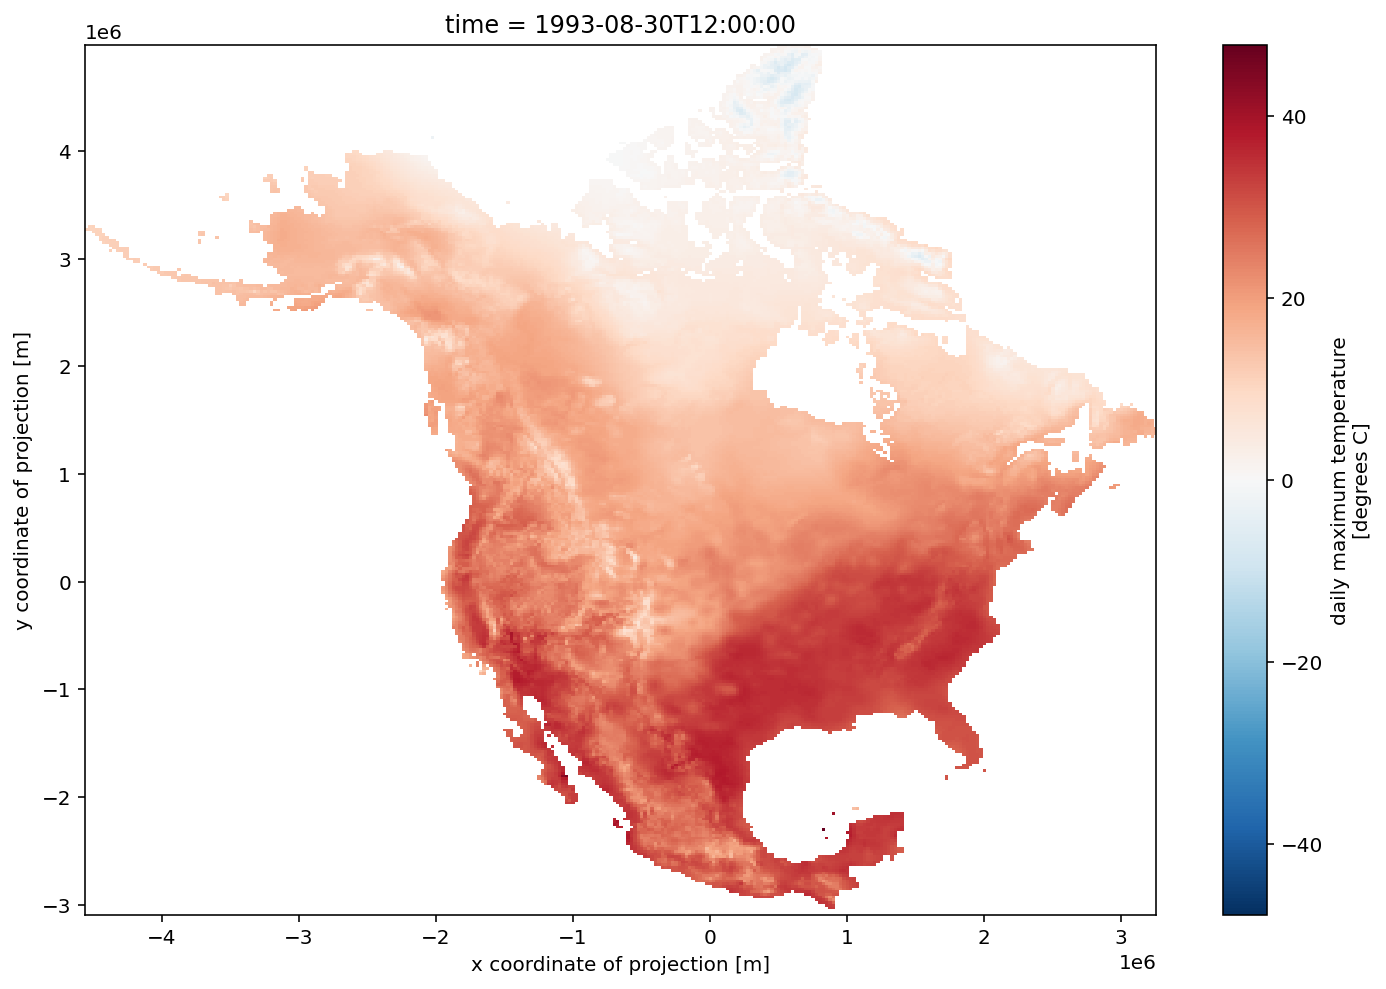

In [31]:
ds.coarsen(x=25,y=25,boundary='pad').mean()['tmax'].sel(time='1993-08-30').plot()

In [4]:
# projection_x_coordinate s
x1 = -3e6
x2 = -1e6
y1 = 0
y2 = 3e6
year = '1993'

ds_seattle = ds.sel(time=year)\
        .coarsen(x=5,y=5,boundary='trim').mean()['tmax']\
        .where((ds.x>x1) & (ds.x<x2) & (ds.y>y1) & (ds.y<y2))


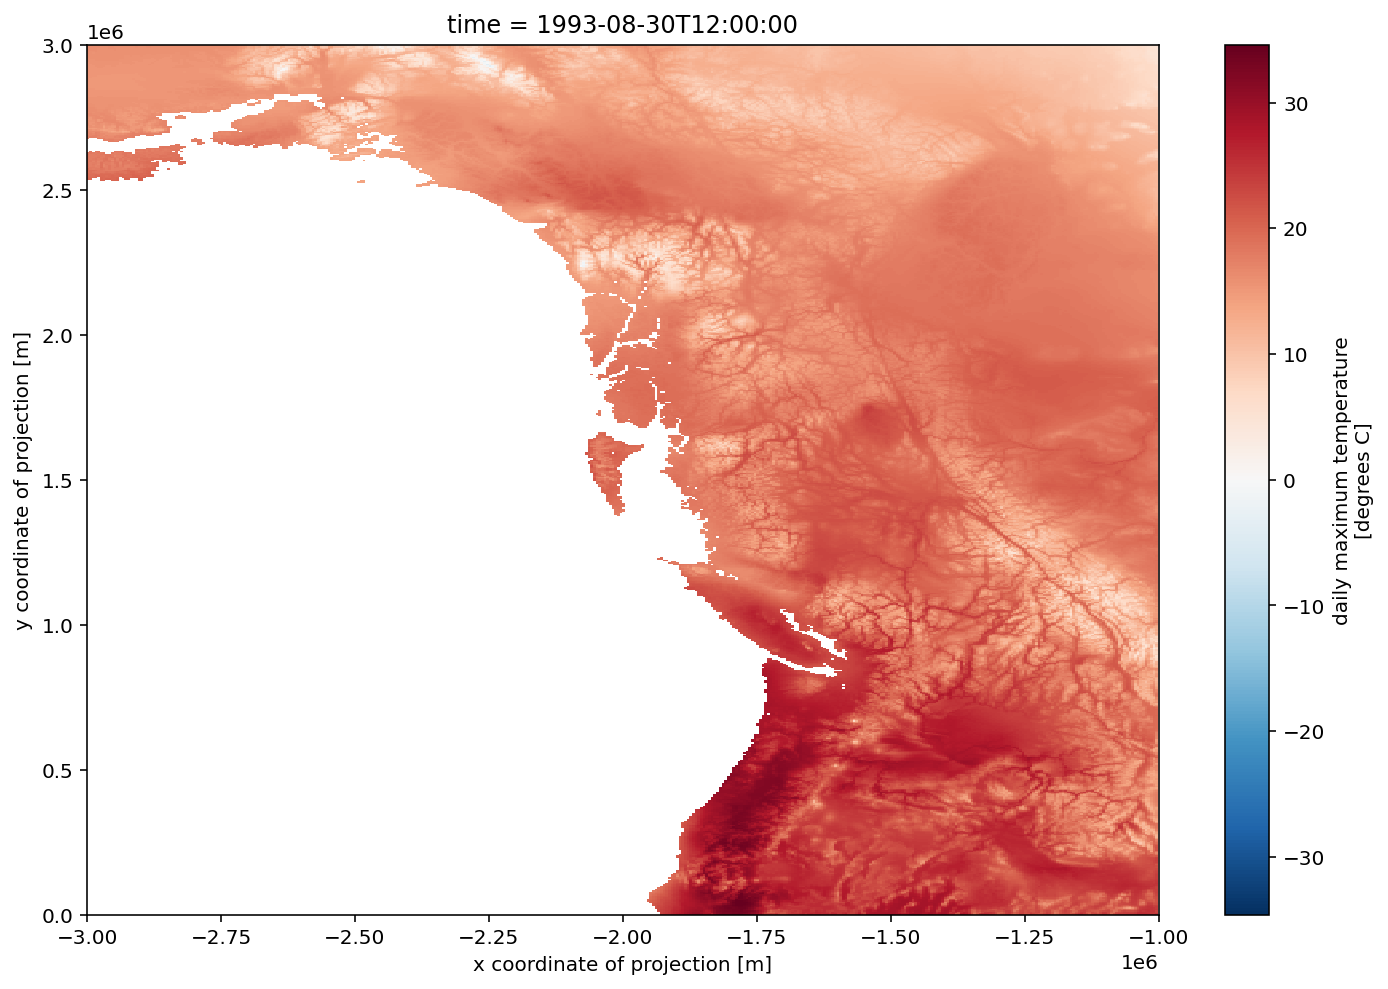

In [5]:
ds_seattle.sel(time=f'{year}-08-30').plot(xlim=[x1,x2],ylim=[y1,y2])

In [54]:
ds_seattle

<xarray.DataArray 'tmax' (time: 365, y: 1615, x: 1562)>
dask.array<where, shape=(365, 1615, 1562), dtype=float32, chunksize=(365, 57, 117), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) float64 4.982e+06 4.977e+06 4.972e+06 ... -3.083e+06 -3.088e+06
  * x        (x) float64 -4.558e+06 -4.553e+06 ... 3.242e+06 3.247e+06
    lat      (y, x) float32 dask.array<chunksize=(56, 116), meta=np.ndarray>
    lon      (y, x) float32 dask.array<chunksize=(56, 116), meta=np.ndarray>
  * time     (time) datetime64[ns] 1993-01-01T12:00:00 ... 1993-12-31T12:00:00
Attributes:
    cell_methods:  area: mean time: maximum
    grid_mapping:  lambert_conformal_conic
    long_name:     daily maximum temperature
    units:         degrees C

In [5]:
################################
# Utils
################################

def get_xy_meshgrid(arr_tmax3d:np.ndarray) -> np.ndarray:
    """create grid for all x,y coordinate pairs [0,1],[0,2],..[283,583]"""
    
    shape_yx = arr_tmax3d.shape[1:] # np.shape order -> zyx
    arr_y = np.arange(shape_yx[0])
    arr_x = np.arange(shape_yx[1])
    ac = np.array(np.meshgrid(arr_x, arr_y)).T.reshape(-1, 2)
    
    return ac

def print_stats(arr:np.ndarray) -> None:
    size = round(arr_tmax3d.nbytes/1e9,2)
    shp = arr_tmax3d.shape
    print(f"""processing.. year={year}, shape z,y,x={shp}, in-memory={size} GB""")

In [6]:
%%time
year = '1993'
arr_tmax3d = ds_seattle.sel(time=year).values
timestamps = ds_seattle.sel(time=year)['time'].values

CPU times: user 5.19 s, sys: 2.74 s, total: 7.93 s
Wall time: 3min 34s


In [11]:
################################
# UPDATED core algorithm to flag heat extremes
################################

# This new algorithm now flags the heat periods not with int 1, but a float based 
# on the 'severity' of each event. The severity is calculated based on the peak 
# difference of daily tmax vs the compared baseline (avg or rolloing avg 
# - based on our final definition).

# input: 1D tmax data
# output: same-size 1D flags where heat event == True

# algorithm coefs:
TEMP_DIFF_THRESHOLD = 3 # Celcius (or K)
PERSISTED_FOR_MIN = 3 # days
    
def flag_heat_events(arr_tmax1d: np.array, timestamps: np.array) -> np.array:
    """
    # Same logic as in Notebook2, but this time it does not slice the 
    # xarray Dataset every time. Instead, it operates on the numpy array - faster.
    """
    # enrich
    df = pd.DataFrame({'tmax':arr_tmax1d})
    df['mov_avg'] = df.rolling(15, center=True).mean()
    df['diff'] = df['tmax'] - df['mov_avg']
    df['time'] = timestamps

    df['hot'] = df['diff'] > TEMP_DIFF_THRESHOLD 
    df['label'] = df['hot'].diff().ne(False).cumsum()
    df = df.reset_index().reset_index()
    
    # filter
    summer_months = [5,6,7,8,9]
    df['isSummer'] = df['time'].dt.month.isin(summer_months)
    
    dff = df[df['isSummer'] & df['hot']].dropna(subset=['diff']) 
    
    # groupby
    dfg = dff.groupby('label').agg({
        'index':[np.min,np.max,len],
        'diff':np.max
    })
    dfg.columns = ['i1','i2','count','peak_diff']
    dfg = dfg[dfg['count'] >= PERSISTED_FOR_MIN]
    dfg = dfg.drop('count', axis=1)
    dfg = dfg.reset_index(drop=True)

    arr = np.empty(len(df), dtype=np.float64)
    arr[:] = np.nan
    for _, (i, j, peak_diff) in dfg.iterrows():
        arr[int(i):int(j)+1] = peak_diff
        
    return arr


In [ ]:
%%time
print('started..')
import time

# years = np.unique(ds_seattle['time'].dt.year).astype(str)

# for year in years:
    
t1 = time.time()

arr_tmax3d = ds_seattle.sel(time=year).values
timestamps = ds_seattle.sel(time=year)['time'].values

arr_heat3d = np.empty(arr_tmax3d.shape, dtype=np.float64)
arr_heat3d[:] = np.nan

print_stats(arr_heat3d)

# loop through all iX,iY pairs
meshgrid = get_xy_meshgrid(arr_tmax3d)
for i, j in meshgrid:

    arr_tmax1d = arr_tmax3d[:,j,i]
    no_data = np.isnan(arr_tmax1d).all()

    if no_data:
        arr_heat1d = np.empty(arr_tmax1d.shape, dtype=np.float64)
        arr_heat1d[:] = np.nan
    else:
        arr_heat1d = flag_heat_events(arr_tmax1d, timestamps)

    arr_heat3d[:,j,i] = arr_heat1d  

np.save(f'./seattle/arr_heat3d-{year}.npy', arr_heat3d)
print(f'{round((time.time() - t1)/60, 2)}min')

started..


In [15]:
2

2